# Simulate Race

## Settings

In [48]:
# set simulation parameters
RESULTS_DIR = "/content/gdrive/MyDrive/RLF002/sim/Shanghai_2019_pretrained"

RACE_PARAMS_FILE = "/content/racesim/input/parameters/pars_Shanghai_2019.ini"
MCS_PARAMS_FILE = "/content/racesim/input/parameters/pars_mcs.ini"

# set simulation options
sim_opts = {
    # use_prob_infl:        activates probabilistic influences within the race simulation -> lap times, pit stop
    #                       durations, race start performance
    "use_prob_infl": False,
    # create_rand_events:   activates the random creation of FCY (full course yellow) phases and retirements in the race
    #                       simulation -> they will only be created if the according entries in the parameter file
    #                       contain empty lists, otherwise the file entries are used
    "create_rand_events": False,
    # use_vse:              determines if the VSE (virtual strategy engineer) is used to take tire change decisions
    #                       -> the VSE type is defined in the parameter file (VSE_PARS)
    "use_vse": True,
    # no_sim_runs:          number of (valid) races to simulate
    "no_sim_runs": 1,
    # no_workers:           defines number of workers for multiprocess calculations, 1 for single process, >1 for
    #                       multi-process (you can use print(multiprocessing.cpu_count()) to determine the max. number)
    "no_workers": 1,
    # use_print:            set if prints to console should be used or not (does not suppress hints/warnings)
    "use_print": True,
    # use_print_result:     set if result should be printed to console or not
    "use_print_result": True,
    # use_plot:             set if plotting should be used or not
    "use_plot": False
}

vse_paths = {
    # "reinf_nnmodel": "/content/gdrive/MyDrive/RLF002/vse-002/exports/2023-05-21-final/nn_reinforcement_Shanghai_2019.tflite",
    # "reinf_preprocessor": "/content/gdrive/MyDrive/RLF002/vse-002/exports/2023-05-21-final/preprocessor_reinforcement_Shanghai_2019.pkl",
    "reinf_nnmodel": "/content/racesim/input/vse/nn_reinforcement_Shanghai_2019.tflite",
    "reinf_preprocessor": "/content/racesim/input/vse/preprocessor_reinforcement_Shanghai_2019.pkl",
    # "supervised_nnmodel_cc": "/content/racesim/input/vse/nn_supervised_compoundchoice.tflite",
    # "supervised_nnmodel_tc": "/content/racesim/input/vse/nn_supervised_tirechange.tflite",
    # "supervised_preprocessor_cc": "/content/racesim/input/vse/preprocessor_supervised_compoundchoice.pkl",
    # "supervised_preprocessor_tc": "/content/racesim/input/vse/preprocessor_supervised_tirechange.pkl"
}

# VSE type for other drivers: 'basestrategy', 'realstrategy', 'supervised', 'reinforcement'
vse_types = {
    "ALB": "reinforcement",
    "BOT": "reinforcement",
    "GAS": "reinforcement",
    "GIO": "reinforcement",
    "GRO": "reinforcement",
    "HAM": "reinforcement",
    "HUL": "reinforcement",
    "KUB": "reinforcement",
    "KVY": "reinforcement",
    "LEC": "reinforcement",
    "MAG": "reinforcement",
    "NOR": "reinforcement",
    "PER": "reinforcement",
    "RAI": "reinforcement",
    "RIC": "reinforcement",
    "RUS": "reinforcement",
    "SAI": "reinforcement",
    "STR": "reinforcement",
    "VER": "reinforcement",
    "VET": "reinforcement",
}

Mount Google Drive.

In [2]:
from google.colab import drive

drive.mount("/content/gdrive")

Mounted at /content/gdrive


Check Colab settings.

In [3]:
from psutil import virtual_memory

gpu_info = !nvidia-smi
gpu_info = "\n".join(gpu_info)
if gpu_info.find("failed") >= 0:
  print("Not connected to a GPU")
else:
  print(gpu_info)

ram_gb = virtual_memory().total / 1e9
print(f"Your runtime has {ram_gb:.1f} gigabytes of available RAM\n")

if ram_gb < 20:
  print("Not using a high-RAM runtime")
else:
  print("You are using a high-RAM runtime!")

/bin/bash: nvidia-smi: command not found
Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


## Installation

Install code repository

In [4]:
!git clone --depth 1 https://github.com/pezon/msca-race-simulation 
!cp -R msca-race-simulation/* .

Cloning into 'msca-race-simulation'...
remote: Enumerating objects: 363, done.
remote: Counting objects: 100% (363/363), done.
remote: Compressing objects: 100% (302/302), done.
remote: Total 363 (delta 177), reused 213 (delta 52), pack-reused 0
Receiving objects: 100% (363/363), 3.65 MiB | 21.61 MiB/s, done.
Resolving deltas: 100% (177/177), done.


Install dependencies.

In [5]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 624.4/624.4 kB 45.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 81.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 84.7 MB/s eta 0:00:00
  Created wheel for gym: filename=gym-0.23.0-py3-none-any.whl size=697642 sha256=54d13a583ea4f062e885024f406aee51f6ffe9a741d992598ee879c4498dc15d
  Stored in directory: /root/.cache/pip/wheels/3d/6f/b4/3991d4fae11d0ecb0754c11cc1b4e7745012850da4efaaf0b1
Successfully built gym
  Attempting uninstall: tensorflow-probability
    Found existing installation: tensorflow-probability 0.20.1
    Uninstalling tensorflow-probability-0.20.1:
      Succes

## Initialization

Import libraries

In [60]:
from concurrent import futures  # required for parallel computing
import os
import pickle
import time
import warnings
from datetime import datetime
from pathlib import Path
from pprint import pprint

import numpy as np

import racesim
import helper_funcs
from racesim.src.check_pars import check_pars
from racesim.src.import_pars import import_pars
from racesim.src.race_handle import race_handle
from racesim.src.mcs_analysis import mcs_analysis

warnings.filterwarnings("ignore")

run_id = datetime.today().strftime("%Y-%m-%d-%M-%H")

# Set working directories
results_dir = Path(RESULTS_DIR)
run_dir = results_dir / "simulations" / run_id
results_dir = run_dir / "results"
invalid_dir = run_dir / "invalid"
samples_dir = run_dir / "samples"

# Create directories
results_dir.mkdir(exist_ok=True, parents=True)
invalid_dir.mkdir(exist_ok=True, parents=True)
samples_dir.mkdir(exist_ok=True, parents=True)

print(f"{results_dir=!s}")
print(f"{invalid_dir=!s}")
print(f"{samples_dir=!s}")

results_dir=/content/gdrive/MyDrive/RLF002/sim/Shanghai_2019_pretrained/simulations/2023-05-21-41-21/results
invalid_dir=/content/gdrive/MyDrive/RLF002/sim/Shanghai_2019_pretrained/simulations/2023-05-21-41-21/invalid
samples_dir=/content/gdrive/MyDrive/RLF002/sim/Shanghai_2019_pretrained/simulations/2023-05-21-41-21/samples


## Check parameters

Load and check parameters

In [51]:
# Load parameters
pars_in, _ = import_pars(
    use_print=sim_opts["use_print"],
    use_vse=sim_opts["use_vse"],
    race_pars_file=RACE_PARAMS_FILE,
    mcs_pars_file=MCS_PARAMS_FILE)

# Check parameters
racesim.src.check_pars.check_pars(
    sim_opts=sim_opts,
    pars_in=pars_in)

INFO: Loading race parameters...
INFO: Loading MCS parameters...
INFO: Checking user input...
INFO: FCY phases for the race simulation were set as follows: [[0.818, 1.392, 'VSC', None, None]]
INFO: Retirements for the race simulation were set as follows: [['HUL', 16.5], ['KVY', 41.5], ['NOR', 50.5]]
INFO: Using VSE (virtual strategy engineer) to take tire change decisions!


VSE Settings

In [52]:
# Update VSE parameters
pars_in["vse_pars"]["vse_type"] = vse_types

print("VSE types:")
pprint(pars_in['vse_pars']['vse_type'])

print("VSE paths:")
pprint(vse_paths)

VSE types:
{'ALB': 'reinforcement',
 'BOT': 'reinforcement',
 'GAS': 'reinforcement',
 'GIO': 'reinforcement',
 'GRO': 'reinforcement',
 'HAM': 'reinforcement',
 'HUL': 'reinforcement',
 'KUB': 'reinforcement',
 'KVY': 'reinforcement',
 'LEC': 'reinforcement',
 'MAG': 'reinforcement',
 'NOR': 'reinforcement',
 'PER': 'reinforcement',
 'RAI': 'reinforcement',
 'RIC': 'reinforcement',
 'RUS': 'reinforcement',
 'SAI': 'reinforcement',
 'STR': 'reinforcement',
 'VER': 'reinforcement',
 'VET': 'reinforcement'}
VSE paths:
{'reinf_nnmodel': '/content/racesim/input/vse/nn_reinforcement_Shanghai_2019.tflite',
 'reinf_preprocessor': '/content/racesim/input/vse/preprocessor_reinforcement_Shanghai_2019.pkl'}


Race parameters

In [26]:
pars_in["race_pars"]

{'season': 2019,
 'tot_no_laps': 56,
 'min_t_dist': 0.5,
 'min_t_dist_sc': 0.8,
 't_duel': 0.3,
 't_overtake_loser': 0.3,
 'use_drs': True,
 'drs_window': 1.0,
 'drs_allow_lap': 3,
 'drs_sc_delay': 2,
 'participants': ['HAM',
  'RIC',
  'MAG',
  'HUL',
  'KVY',
  'RAI',
  'VET',
  'BOT',
  'PER',
  'GRO',
  'SAI',
  'VER',
  'GIO',
  'STR',
  'GAS',
  'LEC',
  'NOR',
  'ALB',
  'RUS',
  'KUB']}

Track parameters

In [27]:
pars_in["track_pars"]

{'name': 'Shanghai',
 't_q': 91.547,
 't_gap_racepace': 1.812,
 't_lap_sens_mass': 0.031,
 't_pit_tirechange_min': 1.9,
 't_pitdrive_inlap': 4.881,
 't_pitdrive_outlap': 15.045,
 't_pitdrive_inlap_fcy': 2.512,
 't_pitdrive_outlap_fcy': 12.04,
 't_pitdrive_inlap_sc': 0.545,
 't_pitdrive_outlap_sc': 11.37,
 'pits_aft_finishline': True,
 't_loss_pergridpos': 0.139,
 't_loss_firstlap': 2.238,
 't_gap_overtake': 1.5,
 't_gap_overtake_vel': -0.037,
 't_drseffect': -0.553,
 'mult_t_lap_sc': 1.6,
 'mult_t_lap_fcy': 1.4}

Tire degradation parameters fitted to driver

In [28]:
pars_in["tireset_pars"]["LEC"]

{'tire_deg_model': 'lin',
 'mult_tiredeg_sc': 0.25,
 'mult_tiredeg_fcy': 0.5,
 't_add_coldtires': 1.0,
 'A3': {'k_0': 0.4731,
  'k_1_lin': 0.0963,
  'k_1_quad': 0.0937,
  'k_2_quad': 0.0002},
 'A4': {'k_0': 0.0, 'k_1_lin': 0.1501, 'k_1_quad': 0.1486, 'k_2_quad': 0.0001},
 'A6': {'k_0': 1.3218,
  'k_1_lin': 0.0367,
  'k_1_quad': 0.0323,
  'k_2_quad': 0.0003}}

Car/team parameters

In [29]:
pars_in["car_pars"]["Ferrari"]

{'drivetype': 'combustion',
 'manufacturer': 'Ferrari',
 't_car': 0.317,
 'm_fuel': 110.0,
 'b_fuel_perlap': 1.964,
 'energy': None,
 'energy_perlap': None,
 'mult_consumption_sc': 0.25,
 'mult_consumption_fcy': 0.5,
 'auto_consumption_adjust': True,
 't_pit_tirechange_add': 0.584,
 't_pit_refuel_perkg': None,
 't_pit_charge_perkwh': None,
 'color': '#DC0000',
 'p_failure': 0.086,
 't_pit_var_fisk_pars': [2.414, -0.153, 0.737]}

Driver parameters

In [30]:
pars_in["driver_pars"]["LEC"]

{'carno': 16,
 'name': 'Charles Leclerc',
 'initials': 'LEC',
 'team': 'Ferrari',
 't_driver': 0.0,
 'strategy_info': [[0, 'A4', 2, 0.0], [22, 'A3', 0, 0.0], [42, 'A4', 0, 0.0]],
 'p_grid': 4,
 't_teamorder': 0.0,
 'vel_max': 325.6,
 'p_accident': 0.058,
 't_lap_var_sigma': 0.533,
 't_startperf': {'mean': -0.042, 'sigma': 0.125}}

Race day events: full course yellow and retirements

In [31]:
pars_in["event_pars"]

{'fcy_data': {'phases': [[0.818, 1.392, 'VSC', None, None]],
  'domain': 'progress'},
 'retire_data': {'retirements': [['HUL', 16.5], ['KVY', 41.5], ['NOR', 50.5]],
  'domain': 'progress'}}

In [32]:
pars_in["monte_carlo_pars"]

{'min_dist_sc': 1.5,
 'min_dist_vsc': 1.5,
 'ref_driver': 'HAM',
 'p_sc_quant': [0.455, 0.413, 0.099, 0.033],
 'p_sc_start': [0.364, 0.136, 0.136, 0.08, 0.193, 0.091],
 'p_sc_duration': [0.0,
  0.182,
  0.25,
  0.227,
  0.193,
  0.057,
  0.068,
  0.023,
  0.0,
  0.0],
 'p_vsc_aft_failure': 0.227,
 'p_vsc_duration': [0.479, 0.396, 0.021, 0.104]}

## Simulate 

Uses single processor approach.

In [58]:
# create list containing the simulated race object (single run) or dicts with valid results (multiple runs)
race_results = []

# save start time for runtime calculation
if sim_opts["use_print"]:
    print("INFO: Starting simulations...")
t_start = time.perf_counter()

# iteration variables
no_sim_runs_left = sim_opts["no_sim_runs"]  # counter for the number of races left for simulation
ctr_invalid = 0                             # counter for the number of simulated races marked as invalid

# SINGLE PROCESS ---------------------------------------------------------------------------------------------------
while no_sim_runs_left > 0:
    # simulate race
    race = race_handle(
        pars_in=pars_in,
        use_prob_infl=sim_opts["use_prob_infl"],
        create_rand_events=sim_opts["create_rand_events"],
        vse_paths=vse_paths)
    no_sim_runs_left -= 1

    # CASE 1: result is valid
    if race.result_status == 0:
        # save race object for later evaluation (single race) or simple race results (MCS)
        if sim_opts["no_sim_runs"] > 1:
            race_results.append(race.get_race_results())
        else:
            race_results.append(race)

    # CASE 2: result is invalid
    else:
        # increase no_sim_runs_left
        ctr_invalid += 1
        no_sim_runs_left += 1

        # pickle race object for further analysis
        if race.result_status >= 10 or race.result_status == -1:
            cur_time_str = time.strftime("%Y%m%d_%H%M%S")
            invalid_race_file = invalid_dir / f"{cur_time_str}_invalid_race_{ctr_invalid}_{race.result_status}.pkl"
            with open(invalid_race_file, "wb") as fh:
                pickle.dump(race, fh)

    # print progressbar
    if sim_opts["use_print"]:
        helper_funcs.src.progressbar.progressbar(
            i=sim_opts["no_sim_runs"] - no_sim_runs_left,
            i_total=sim_opts["no_sim_runs"],
            prefix="INFO: Simulation progress:")

# print number of invalid races
if sim_opts["use_print"]:
    print(f"INFO: There were {ctr_invalid} invalid races!")

# print runtime into console window
if sim_opts["use_print"]:
    runtime = time.perf_counter() - t_start
    print(f"INFO: Simulation runtime: {runtime:.3f}s ({runtime / sim_opts['no_sim_runs'] * 1000:.3f}ms per race)")

INFO: Starting simulations...
INFO: Simulation progress: |██████████████████████████████████████████████████| 100.0% 
INFO: There were 0 invalid races!
INFO: Simulation runtime: 0.309s (309.327ms per race)


## Results

In [59]:
# For a single race...
if sim_opts["no_sim_runs"] == 1:
    race_results[0].check_valid_result()

    if sim_opts["use_print_result"]:
        race_results[0].print_result()
        race_results[0].print_details()

    if sim_opts["use_plot"]:
        # race_results[0].plot_laptimes()
        # race_results[0].plot_positions()
        # race_results[0].plot_racetime_diffto_refdriver(1)
        # race_results[0].plot_raceprogress_over_racetime()

        # laps_simulated = race_results[0].cur_lap
        # t_race_winner = np.sort(race_results[0].racetimes[laps_simulated, :])[0]
        # race_results[0].plot_racetime_diffto_reflaptime(ref_laptime=t_race_winner / laps_simulated)
        pass

    # evaluation
    race_results[0].print_race_standings(racetime=2520.2)

    # save lap times, race times and positions to csv files
    race_results[0].export_results_as_csv(results_path=results_dir)

    # pickle race object for possible CI testing
    sample_file_path = samples_dir / f"testobj_racesim_{pars_in['track_pars']['name']}_{pars_in['race_pars']['season']}.pkl"
    with open(sample_file_path, "wb") as fh:
        pickle.dump(race_results[0], fh)

RESULT: Pre-simulation base strategy (by VSE) for HAM: [[0, 'A4', 2, 0.0], [18, 'A4', 0, 0.0], [35, 'A3', 0, 0.0]]
RESULT: Pre-simulation race duration for HAM: 5468.145s
RESULT: Simulation result:
     pos  carno   t_race    gap    int  best_t_lap  no_laps status                                  strategy_info
BOT    1     77 5464.968  0.000  0.000      95.174       56      F              [0, 'A4'], [15, 'A3'], [30, 'A4']
HAM    2     44 5471.836  6.868  6.868      94.547       56      F              [0, 'A4'], [25, 'A4'], [40, 'A3']
VER    3     33 5497.956 32.988 26.120      96.042       56      F                          [0, 'A4'], [27, 'A3']
VET    4      5 5514.725 49.757 16.768      95.899       56      F              [0, 'A4'], [14, 'A4'], [32, 'A3']
LEC    5     16 5521.277 56.309  6.552      94.552       56      F  [0, 'A4'], [12, 'A4'], [30, 'A3'], [50, 'A3']
RIC    6      3 5531.614 66.646 10.338      95.718       56      F                          [0, 'A6'], [43, 'A3']
GAS 

Plots!

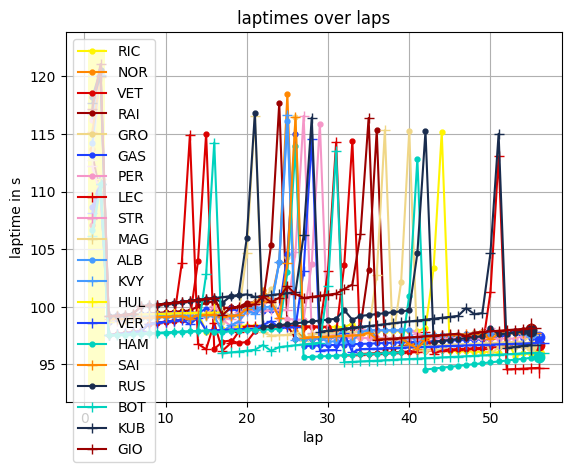

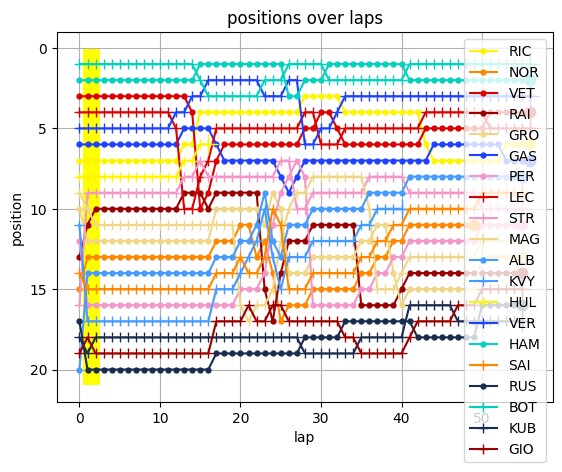

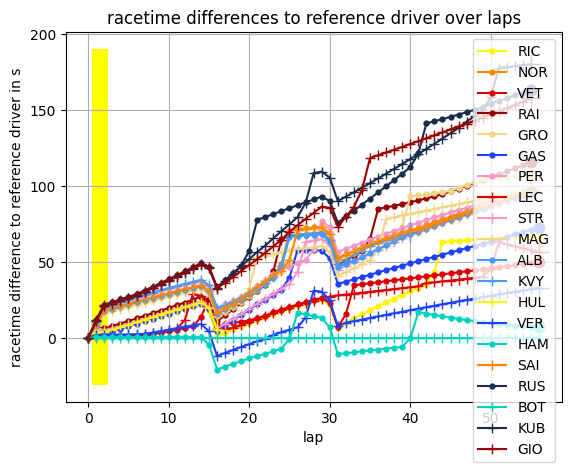

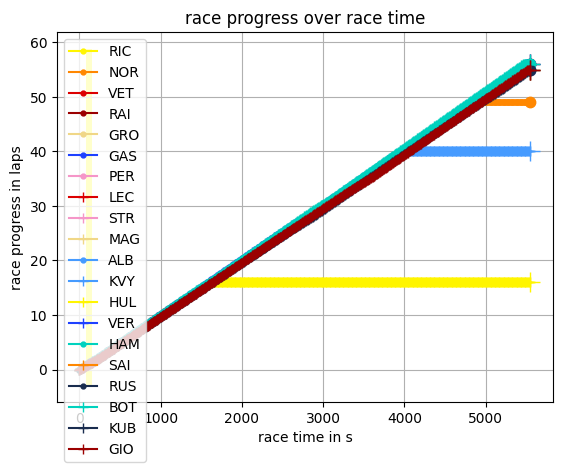

In [64]:
race_results[0].plot_laptimes()
race_results[0].plot_positions()
race_results[0].plot_racetime_diffto_refdriver(1)
race_results[0].plot_raceprogress_over_racetime()

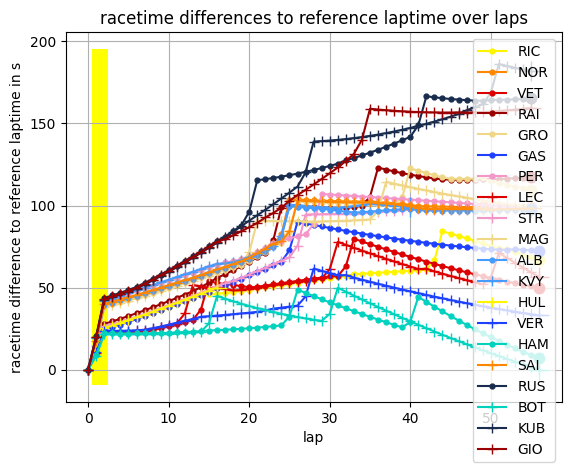

In [65]:
laps_simulated = race_results[0].cur_lap
t_race_winner = np.sort(race_results[0].racetimes[laps_simulated, :])[0]
race_results[0].plot_racetime_diffto_reflaptime(ref_laptime=t_race_winner / laps_simulated)

Race results histogram (for multiple races)

In [61]:
# For multiple races...
if sim_opts["no_sim_runs"] > 1:
    mcs_analysis(
        race_results=race_results,
        use_print_result=sim_opts["use_print_result"],
        use_plot=sim_opts["use_plot"])

## Debugging

Debugging differences b/w our models and pre-trained models

In [68]:
import tensorflow as tf 

# our model:
vse_model_path_ours = "/content/gdrive/MyDrive/RLF002/vse-002/exports/2023-05-21-final/nn_reinforcement_Shanghai_2019.tflite"
# pre-trained model:
vse_model_path_theirs = "/content/racesim/input/vse/nn_reinforcement_Shanghai_2019.tflite"


def create_model(vse_model_path):
  qnet = tf.lite.Interpreter(model_path=vse_model_path)
  qnet.allocate_tensors()
  input_index = qnet.get_input_details()[0]["index"]
  print("Input:")
  pprint(qnet.get_input_details())
  output_index = qnet.get_output_details()[0]["index"]
  print("Output:")
  pprint(qnet.get_output_details())
  return qnet

print("Pretrained:")
create_model(vse_model_path_theirs)
print("Our agent:")
create_model(vse_model_path_ours)

Pretrained:
Input:
[{'dtype': <class 'numpy.float32'>,
  'index': 0,
  'name': 'input_1',
  'quantization': (0.0, 0),
  'quantization_parameters': {'quantized_dimension': 0,
                              'scales': array([], dtype=float32),
                              'zero_points': array([], dtype=int32)},
  'shape': array([ 1, 40], dtype=int32),
  'shape_signature': array([ 1, 40], dtype=int32),
  'sparsity_parameters': {}}]
Output:
[{'dtype': <class 'numpy.float32'>,
  'index': 9,
  'name': 'Identity',
  'quantization': (0.0, 0),
  'quantization_parameters': {'quantized_dimension': 0,
                              'scales': array([], dtype=float32),
                              'zero_points': array([], dtype=int32)},
  'shape': array([1, 4], dtype=int32),
  'shape_signature': array([1, 4], dtype=int32),
  'sparsity_parameters': {}}]
Our agent:
Input:
[{'dtype': <class 'numpy.int32'>,
  'index': 0,
  'name': 'action_0_step_type:0',
  'quantization': (0.0, 0),
  'quantization_parame